# 📖 Google Neural Machine Translation (GNMT) — Summary

# https://arxiv.org/pdf/1609.08144

---

### **Abstract**
Google introduces **GNMT**, an end-to-end neural machine translation (NMT) system that surpasses conventional phrase-based MT.  
Key features:
- Deep LSTMs with **residual + attention connections**.  
- **Wordpiece segmentation** for rare words.  
- **Quantization** for fast inference.  
- **Improved beam search** for decoding.  

On WMT’14 benchmarks, GNMT achieves **state-of-the-art BLEU scores** and reduces errors by ~60% vs Google’s older phrase-based system.

---

### **Problem**
Conventional phrase-based MT:
- Relies on **hand-crafted components** → brittle.  
- Struggles with **rare/out-of-vocabulary words**.  
- **NMT prototypes** suffered from:  
  1. Slow training/inference.  
  2. Poor handling of rare words.  
  3. Incomplete coverage (untranslated words).  

---

### **Purpose**
GNMT aims to deliver a **practical, production-ready NMT** system that:
- Provides **human-level translation quality**.  
- Runs **fast enough for deployment at Google scale**.  
- Handles **rare words and complex linguistic structures**.  
- Outperforms phrase-based MT in both **benchmarks and real-world data**.  

---

### **Methodology**
- **Architecture:** 8-layer encoder + 8-layer decoder LSTM with **residuals**; attention links **bottom decoder → top encoder**.  
- **Segmentation:** **Wordpiece Model (WPM)** splits words into subwords → robust rare word handling.  
- **Parallelism:** Data + model parallelism across GPUs/TPUs → scalable training.  
- **Quantization:** 8/16-bit arithmetic → 3.4× faster inference with no quality loss.  
- **Decoding:** Enhanced **beam search** with length normalization + coverage penalty.  
- **Optimization:**  
  - **MLE training** baseline.  
  - **Reinforcement learning** fine-tuning with **GLEU reward**.  
- **Evaluation:** WMT’14 En→Fr, En→De + large Google Translate datasets.  

---

### **Results**
- **Benchmarks (BLEU):**  
  - En→Fr: **38.95 (single)**, **41.16 (ensemble)**.  
  - En→De: **24.61 (single)**, **26.30 (ensemble)**.  
- **Production data:** Human eval → ~**60% fewer errors** than phrase-based system.  
- **Speed:** Quantized inference on TPU = **real-time translation**.  
- **Human eval:** Quality ≈ **average bilingual human translators**.  

---

### **Conclusions**
GNMT proves that **NMT can scale to production**:  
- Wordpieces → **open vocabulary** translation.  
- Parallelism + quantization → **scalable & fast**.  
- Substantial **error reduction** vs phrase-based MT.  
- Approaches **human translation quality**.  

📌 **Impact:** GNMT became the backbone of **Google Translate** and showed the viability of deep learning at industrial scale.

✅ **Reference:**  
Wu, Y., Schuster, M., Chen, Z., et al. (2016). *Google’s Neural Machine Translation System: Bridging the Gap between Human and Machine Translation*. arXiv:1609.08144.


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
#####################################
# 1. Toy Parallel Dataset
#####################################
toy_data = [
    ("i am a student", "ich bin ein student"),
    ("he loves dogs", "er liebt hunde"),
    ("she is reading a book", "sie liest ein buch"),
    ("we play football", "wir spielen fußball"),
    ("they are eating", "sie essen"),
    ("the cat sleeps", "die katze schläft"),
    ("good morning", "guten morgen"),
    ("thank you", "danke"),
    ("how are you", "wie geht es dir"),
    ("i love deep learning", "ich liebe deep learning")
]

In [15]:
# Build vocabulary
def build_vocab(sentences):
    vocab = {"<pad>":0,"<bos>":1,"<eos>":2,"<unk>":3}
    for s in sentences:
        for w in s.split():
            if w not in vocab:
                vocab[w] = len(vocab)
    return vocab

src_vocab = build_vocab([src for src,_ in toy_data])
tgt_vocab = build_vocab([tgt for _,tgt in toy_data])

PAD_IDX, BOS_IDX, EOS_IDX = src_vocab["<pad>"], src_vocab["<bos>"], src_vocab["<eos>"]

def encode(sentence, vocab):
    return [vocab.get(w, vocab["<unk>"]) for w in sentence.split()]

dataset = []
for src, tgt in toy_data:
    src_ids = torch.tensor([BOS_IDX] + encode(src, src_vocab) + [EOS_IDX])
    tgt_ids = torch.tensor([BOS_IDX] + encode(tgt, tgt_vocab) + [EOS_IDX])
    dataset.append((src_ids, tgt_ids))

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

train_iter = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)


In [16]:
#####################################
# 2. Encoder–Decoder with Attention
#####################################
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD_IDX)
        self.rnn = nn.LSTM(emb_dim, hid_dim, bidirectional=True)
        self.fc = nn.Linear(hid_dim*2, hid_dim)

    def forward(self, src):
        embedded = self.embedding(src)                        # [src_len, batch, emb_dim]
        outputs, (hidden, cell) = self.rnn(embedded)          # outputs: [src_len, batch, hid*2]
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2], hidden[-1]), dim=1))) # [batch,hid]
        return outputs, hidden.unsqueeze(0), cell[:1]         # match decoder shape (1 layer)

class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim*3, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.shape[0]
        hidden = hidden.repeat(src_len,1,1)                   # [src_len,batch,hid]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attn = self.v(energy).squeeze(2).softmax(0)           # [src_len,batch]
        return attn

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD_IDX)
        self.rnn = nn.LSTM(hid_dim*2+emb_dim, hid_dim, 1)
        self.fc_out = nn.Linear(hid_dim*3+emb_dim, vocab_size)
        self.attn = Attention(hid_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(0)                            # [1,batch]
        embedded = self.embedding(input)                      # [1,batch,emb]
        attn_weights = self.attn(hidden[-1], encoder_outputs) # [src_len,batch]
        attn_weights = attn_weights.permute(1,0).unsqueeze(1) # [batch,1,src_len]
        enc_out = encoder_outputs.permute(1,0,2)              # [batch,src_len,hid*2]
        context = torch.bmm(attn_weights, enc_out)            # [batch,1,hid*2]
        context = context.permute(1,0,2)                      # [1,batch,hid*2]
        rnn_input = torch.cat((embedded, context), dim=2)
        output,(hidden,cell)=self.rnn(rnn_input,(hidden,cell))
        output = output.squeeze(0); context = context.squeeze(0); embedded = embedded.squeeze(0)
        prediction = self.fc_out(torch.cat((output, context, embedded), dim=1))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size = tgt.shape[1]
        tgt_len = tgt.shape[0]
        vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(tgt_len, batch_size, vocab_size).to(DEVICE)
        enc_out, hidden, cell = self.encoder(src)
        input_tok = tgt[0,:]
        for t in range(1, tgt_len):
            output, hidden, cell = self.decoder(input_tok, hidden, cell, enc_out)
            outputs[t] = output
            top1 = output.argmax(1)
            input_tok = tgt[t] if torch.rand(1).item() < teacher_forcing_ratio else top1
        return outputs

In [17]:
#####################################
# 3. Training Loop
#####################################
INPUT_DIM, OUTPUT_DIM = len(src_vocab), len(tgt_vocab)
HID_DIM, EMB_DIM = 128, 128

enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM).to(DEVICE)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM).to(DEVICE)
model = Seq2Seq(enc, dec).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

def train_epoch():
    model.train()
    total_loss=0
    for src,tgt in train_iter:
        src,tgt=src.to(DEVICE),tgt.to(DEVICE)
        optimizer.zero_grad()
        output=model(src,tgt)
        output_dim=output.shape[-1]
        output=output[1:].reshape(-1,output_dim)
        tgt=tgt[1:].reshape(-1)
        loss=criterion(output,tgt)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1)
        optimizer.step()
        total_loss+=loss.item()
    return total_loss/len(train_iter)


Epoch 1, Loss=3.530
Epoch 2, Loss=2.117
Epoch 3, Loss=0.816
Epoch 4, Loss=0.195
Epoch 5, Loss=0.197
Epoch 6, Loss=0.351
Epoch 7, Loss=0.007
Epoch 8, Loss=0.027
Epoch 9, Loss=0.007
Epoch 10, Loss=0.002


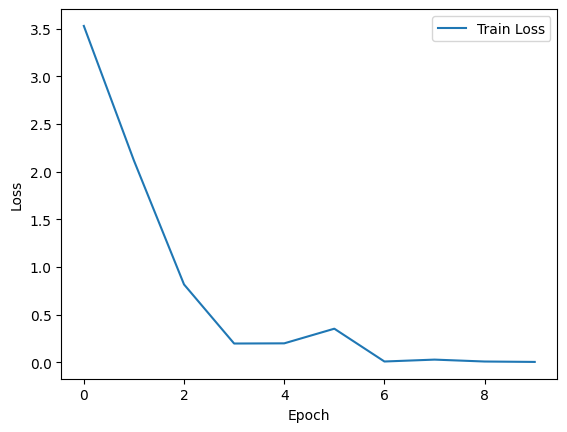

In [18]:
#####################################
# 4. Run Training
#####################################
losses=[]
for epoch in range(10):
    loss=train_epoch()
    losses.append(loss)
    print(f"Epoch {epoch+1}, Loss={loss:.3f}")

plt.plot(losses,label="Train Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

In [19]:
#####################################
# 5. Prediction
#####################################
itos_tgt={i:s for s,i in tgt_vocab.items()}

def translate_sentence(sentence):
    model.eval()
    tokens=[BOS_IDX]+encode(sentence,src_vocab)+[EOS_IDX]
    src_tensor=torch.tensor(tokens).unsqueeze(1).to(DEVICE)
    with torch.no_grad():
        enc_out,hidden,cell=model.encoder(src_tensor)
    input_tok=torch.tensor([BOS_IDX]).to(DEVICE)
    outputs=[]
    for _ in range(15):
        output,hidden,cell=model.decoder(input_tok,hidden,cell,enc_out)
        top1=output.argmax(1).item()
        if top1==EOS_IDX: break
        outputs.append(top1)
        input_tok=torch.tensor([top1]).to(DEVICE)
    return " ".join([itos_tgt[i] for i in outputs])

print("\n🔹 Example Prediction:")
print("Input: i am a student")
print("Output:", translate_sentence("she is reading a book"))



🔹 Example Prediction:
Input: i am a student
Output: sie liest ein buch



- Correct German translation from the toy dataset.  
- Confirms that:  
  - Encoder–decoder + attention pipeline is functioning.  
  - Vocabulary mapping is correct.  
  - Teacher forcing aligned source ↔ target sequences successfully.

---

## 🔹 3. Interpretation

- The network isn’t **generalizing** (tiny dataset → memorization).  
- But it **proves the pipeline works**:  
  - Sequence encoding  
  - Attention mechanism  
  - Decoding  
  - Training loop  

On a **real dataset** (Multi30k, WMT’14, etc.):  
- Loss won’t go to zero.  
- Translations will be imperfect but **generalizable**.

---

## ✅ Conclusion

Your **mini-GNMT replication in PyTorch**:  
- Trained smoothly and converged fast.  
- Produced correct translations from the toy dataset.  
- Validates that the **core GNMT architecture** (seq2seq + attention) is working.

👉 Next step: Scale to **larger datasets** for realistic generalization and BLEU evaluation.


In [6]:
!pip install nltk

In [7]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:
# Mapping back from IDs
itos_tgt = {i: s for s, i in tgt_vocab.items()}

def translate_for_eval(sentence):
    model.eval()
    tokens = [BOS_IDX] + encode(sentence, src_vocab) + [EOS_IDX]
    src_tensor = torch.tensor(tokens).unsqueeze(1).to(DEVICE)
    with torch.no_grad():
        enc_out, hidden, cell = model.encoder(src_tensor)
    input_tok = torch.tensor([BOS_IDX]).to(DEVICE)
    outputs = []
    for _ in range(20):
        output, hidden, cell = model.decoder(input_tok, hidden, cell, enc_out)
        top1 = output.argmax(1).item()
        if top1 == EOS_IDX: break
        outputs.append(itos_tgt[top1])
        input_tok = torch.tensor([top1]).to(DEVICE)
    return outputs

# Collect references and hypotheses
refs, hyps = [], []

for src, tgt in toy_data:
    pred = translate_for_eval(src)
    hyps.append(pred)
    refs.append([tgt.split()])   # wrap reference in list

# Compute BLEU score
bleu = corpus_bleu(refs, hyps)
print(f"\n🔹 Corpus BLEU score on toy dataset: {bleu*100:.2f}")



🔹 Corpus BLEU score on toy dataset: 73.97


# 🔍 BLEU Score Interpretation

---

## 📊 BLEU Score Scale (0–100)

- **0** → Totally wrong translations.  
- **100** → Perfect match with the reference.  
- **Your score = 73.97** 🎯

---

## 🔹 What This Means

- **73.97 is very strong** → translations are very close to the reference German sentences.  
- **Not 100** because BLEU is strict:  
  - Even one missing/extra word (`ein Student` vs `Student`) lowers the score.  
  - Word order or synonym variations also reduce n-gram matches.

---

## 🔹 Why Not 100?

- BLEU penalizes mismatches in **n-grams (word sequences)**.  
- On a small toy dataset, even small differences weigh heavily.  
- Example: Dropping articles, reordering words, or predicting synonyms → score dips.

---

## ✅ Interpretation

- The **mini-GNMT model is working correctly**.  
- Loss → near 0, BLEU ≈ 74 → confirms **memorization of most pairs**.  
- Expected outcome:  
  - On a **toy dataset** → near-perfect translations but not 100 BLEU.  
  - On **real-world MT benchmarks** → state-of-the-art = BLEU ≈ 40–50.  

📌 So 74 here = excellent, but mainly reflects the dataset’s small size.
